## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Def functions

In [2]:
def calibrator(calibration_files):
    
    global mtx, dist
        
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(calibration_files)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
#             img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#             cv2.imshow('img',img)
#             cv2.waitKey(500)

#     cv2.destroyAllWindows()
    # Calibrate a camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                       imgpoints, 
                                                       img.shape[0:2],
                                                       None, None)
    print('Calibrator Done')

In [43]:
def perspective_transformer():
    global src, dst, M, Minv
    
#     src = np.float32([
#         [678, 440],[1279, 720],
#         [0, 720],[595, 440]])

#     # Four desired coordinates
#     dst = np.float32([
#         [1180, 0],[1180, 720],
#         [100, 720],[100, 0]])
    
    # Define the perspective transformation area
    img_width = 1280
    img_height = 720

    bot_width = .76 # percent of bottom
    mid_width = .08
    height_pct = .62
    bottom_trim = .935
    src = np.float32([
        [img_width*(.5-mid_width/2), img_height*height_pct],
        [img_width*(.5+mid_width/2), img_height*height_pct],
        [img_width*(.5+bot_width/2), img_height*bottom_trim],
        [img_width*(.5-bot_width/2), img_height*bottom_trim]
    ])
    
    offset = img_width*.25
    
    dst = np.float32([
        [offset, 0],
        [img_width-offset, 0],
        [img_width-offset, img_height],
        [offset, img_height]
    ])
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

In [4]:
# Edit this function to create your own pipeline.
def thresh_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine these thresholded binary images
    thresh_binary = np.zeros_like(s_channel)
    thresh_binary[(sxbinary==1)|(s_binary==1)] = 1 
    
    return thresh_binary

In [5]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

In [6]:
def sliding_windows_search(img):
    # input: binary warped image
    # 5. Detect lane pixels and fit to find the lane boundary.

    # binary_warped = mpimg.imread('test_images/warped-example.jpg')
    binary_warped = img.astype('uint8')

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, out_img

In [7]:
def cal_curvature(ploty, left_fitx, right_fitx):
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Calculate the offset of the car on the road
    
    lane_center = (left_fitx[-1]+right_fitx[-1])/2
        
    center_diff = (640-lane_center)*xm_per_pix
    
    return left_curverad, right_curverad, center_diff

In [8]:
def lane_mask(img_undist, binary_warped, Minv, ploty, left_fitx, right_fitx):
    # 7. Warp the detected lane boundaries back onto the original image.

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    middle_x = (left_fitx + right_fitx)/2
    middle_pts = np.transpose(np.vstack((middle_x, ploty))).astype(np.int32)
    
#     print(middle_pts.shape)
#     print(middle_pts)
#     plt.plot((left_fitx+right_fitx)/2, ploty, color='yellow')
    cv2.polylines(color_warp, np.int32([middle_pts]), False, (0, 0, 255), thickness=10)
    cv2.arrowedLine(color_warp, (640, 719), (640,690), (255,0,255), 5, tipLength=0.25)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_undist.shape[1], img_undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    
    debug_canvas = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    debug_result = cv2.addWeighted(debug_canvas, 1, color_warp, 0.3, 0)
    
    return result

## Build a lane finding pipeline

In [9]:
def lane_finding(img_orig):
    
    # 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.        
    # mtx, dist are global variables
    
    # 2. Apply a distortion correction to raw images.
    img_undist = cv2.undistort(img_orig, mtx, dist, None, mtx)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    img_thresh = thresh_pipeline(img_undist)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    # src, dst, M, Minv are global variables

    img_birdeye = warper(img_thresh, src, dst)
    img_birdeye_color = warper(img_undist, src, dst)
    
    # 5. Detect lane pixels and fit to find the lane boundary.
    left_fit, right_fit, img_search = sliding_windows_search(img_birdeye)
    
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_birdeye.shape[0]-1, img_birdeye.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curverad, right_curverad, center_diff = cal_curvature(ploty, left_fitx, right_fitx)
    

    
    # 7. Warp the detected lane boundaries back onto the original image.
    result = lane_mask(img_undist, img_birdeye, Minv, ploty, left_fitx, right_fitx)
    cv2.putText(result, 'Radius of Curvature = '+str(round(left_curverad, 3))+'(m)', 
                (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Vehicle is '+str(round(center_diff, 3))+' m off center', 
                (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    canvas = np.zeros([960,1280,3], dtype=np.uint8)
    
    canvas[0:720, 0:1280, :] = result   
    
    
    # For debug, output the 
#     color_thresh_binary = np.dstack(( np.zeros_like(img_thresh), img_thresh, np.zeros_like(img_thresh) ))
#     color_thresh_binary = (color_thresh_binary*255).astype(np.uint8)
    img_debug = img_thresh
    color_debug = np.dstack(( img_debug, img_debug, img_debug ))
    color_debug = (color_debug*255).astype(np.uint8)
    cv2.polylines(color_debug, np.int32([src]), True, (0, 255, 0), thickness=4)
    plot1 = cv2.resize(color_debug, (426, 240))
    
   
    
    img_debug = img_birdeye
    color_debug = np.dstack(( img_debug, img_debug, img_debug ))
    color_debug = (color_debug*255).astype(np.uint8)
    plot3 = cv2.resize(color_debug, (426, 240))
    
    # Plot the searching process
    plot4 = img_search
    left_pts = np.transpose(np.vstack((left_fitx, ploty))).astype(np.int32)    
    right_pts = np.transpose(np.vstack((right_fitx, ploty))).astype(np.int32)
#     print(left_pts.shape);print(left_pts)
#     print(right_pts.shape);print(right_pts)
    cv2.polylines(plot4, np.int32([left_pts]), False, (255, 255, 0), thickness=5)
    cv2.polylines(plot4, np.int32([right_pts]), False, (255, 255, 0), thickness=5)
    plot4 = cv2.resize(img_search, (426, 240))
    
    # Plot the bird eye view
    cv2.polylines(img_birdeye_color, np.int32([dst]), True, (0, 255, 0), thickness=4)
    plot2 = cv2.resize(img_birdeye_color, (426, 240))
    
    # Plot the three contents
    canvas[720:960, 0:426, :] = plot1
    canvas[720:960, 427:427+426, :] = plot2
    canvas[720:960, -427:-1, :] = plot4
    
    return canvas

## Camera Calibration

In [10]:
# Run this once
calibrator('./camera_cal/calibration*.jpg')

# Store the parameters into pickle
# TODO

Calibrator Done


## Define the Perspective Transformation

In [44]:
perspective_transformer()

## Test this Pipeline

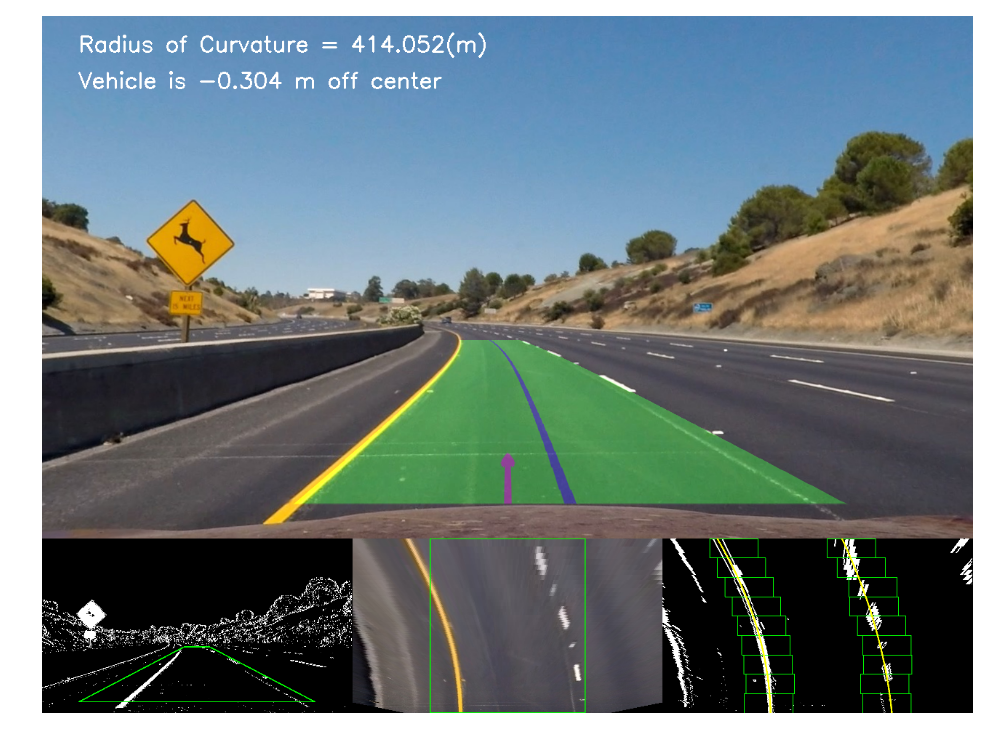

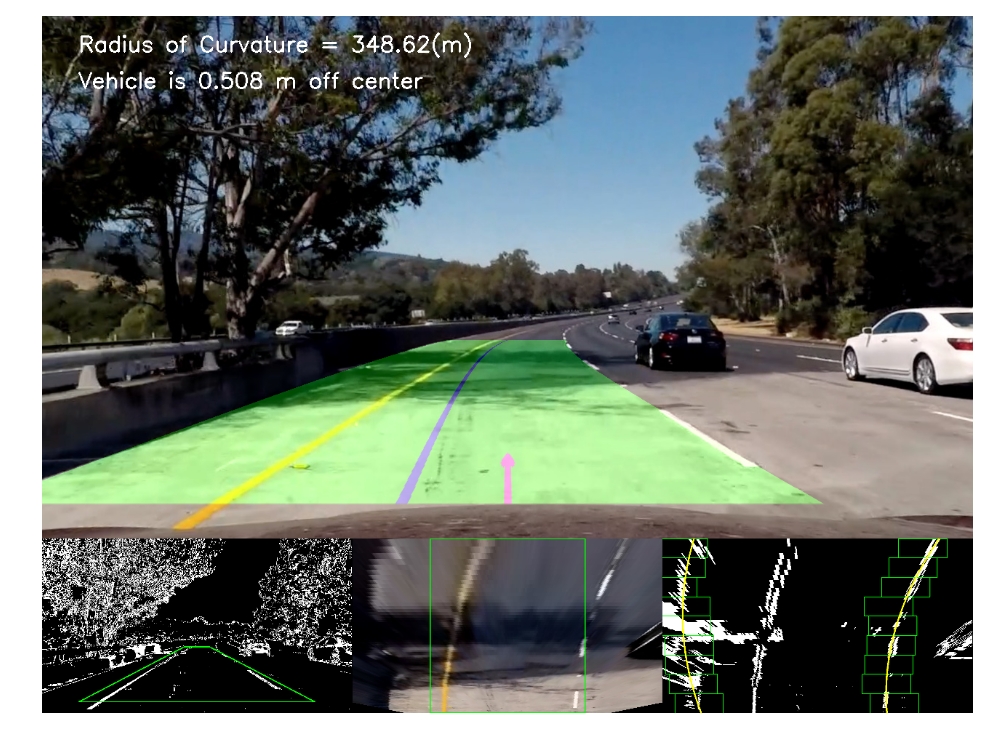

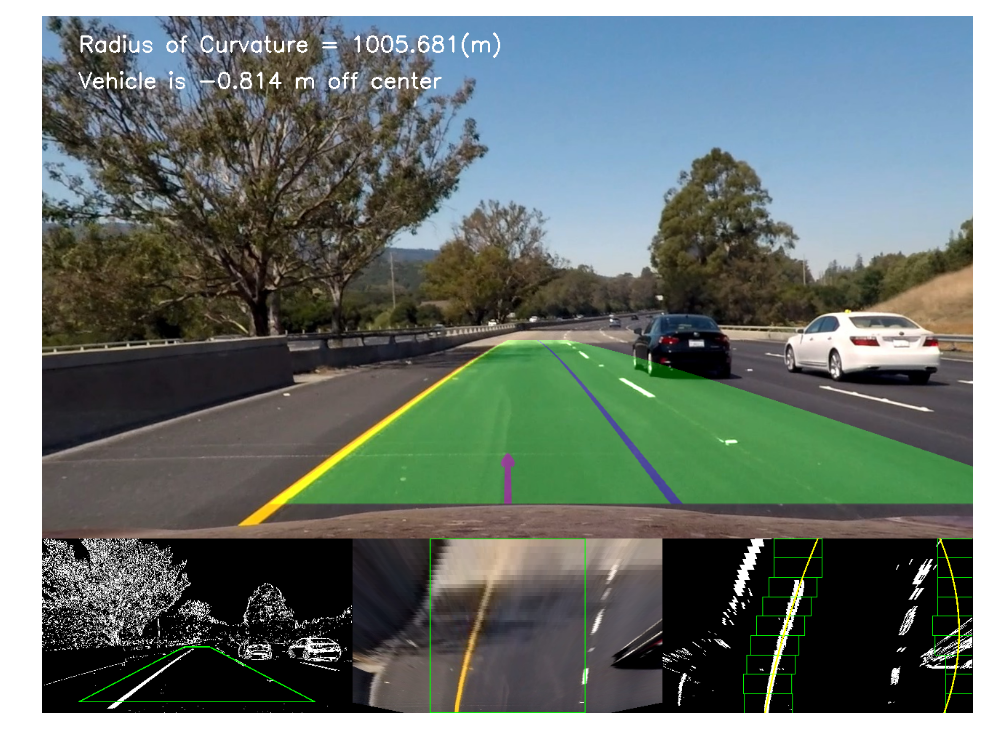

In [46]:
# Make a list of test images
test_files = './test_images/test*.jpg'
images = glob.glob(test_files)

# Step through the list and search for chessboard corners
for fname in images:
    img_orig = cv2.imread(fname)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
#     img_orig = mpimg.imread('test_images/straight_lines.jpg') # 'straight_lines2.jpg'
    img_output = lane_finding(img_orig)
    plt.figure(figsize=(12,9))
    plt.imshow(img_output); plt.axis('off'); plt.show()

## Video Output

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
video1_output = 'project_video_output_try6.mp4'
clip1 = VideoFileClip("project_video.mp4")
video1_clip = clip1.fl_image(lane_finding) #NOTE: this function expects color images!!
%time video1_clip.write_videofile(video1_output, audio=False)

[MoviePy] >>>> Building video project_video_output_try5.mp4
[MoviePy] Writing video project_video_output_try5.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:51<00:00,  3.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_try5.mp4 

Wall time: 6min 53s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video1_output))

In [ ]:
video2_output = 'challenge_video_output_try2.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
video2_clip = clip2.fl_image(lane_finding) #NOTE: this function expects color images!!
%time video2_clip.write_videofile(video2_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video2_output))

In [ ]:
video3_output = 'harder_challenge_video_output_try2.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
video3_clip = clip3.fl_image(lane_finding) #NOTE: this function expects color images!!
%time video3_clip.write_videofile(video3_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video3_output))